Dataset Shape: (569, 32)
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  

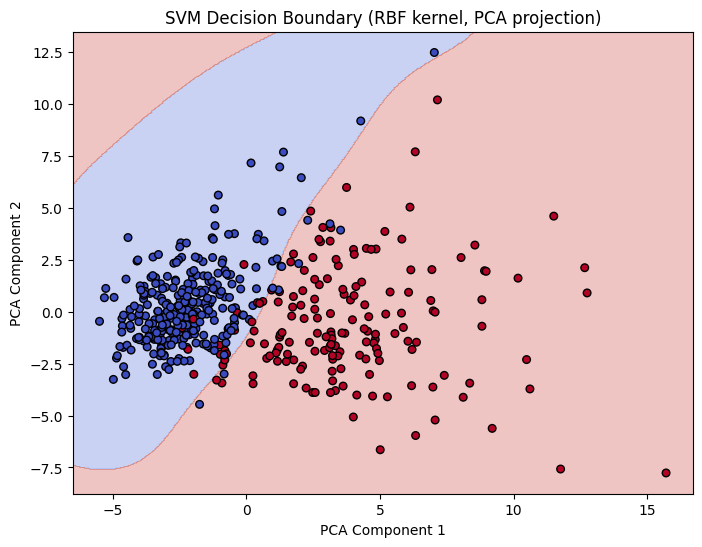

In [5]:
# Task 7: Support Vector Machines (SVM)

#Import Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# -Load Dataset 
df = pd.read_csv(r"C:\Users\rines\Downloads\archive (14)\breast-cancer.csv")
print("Dataset Shape:", df.shape)
print(df.head())

# Preprocessing 
# Drop 'id' since it's not a feature
X = df.drop(["id", "diagnosis"], axis=1)
y = df["diagnosis"]

# Encode diagnosis: M=1, B=0
y = y.map({"M": 1, "B": 0})

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM with Linear Kernel 
svm_linear = SVC(kernel="linear", C=1, random_state=42)
svm_linear.fit(X_train_scaled, y_train)
y_pred_linear = svm_linear.predict(X_test_scaled)

print("\n--- Linear SVM Results ---")
print(confusion_matrix(y_test, y_pred_linear))
print(classification_report(y_test, y_pred_linear))
print("Accuracy:", accuracy_score(y_test, y_pred_linear))

# Train SVM with RBF Kernel
svm_rbf = SVC(kernel="rbf", C=1, gamma="scale", random_state=42)
svm_rbf.fit(X_train_scaled, y_train)
y_pred_rbf = svm_rbf.predict(X_test_scaled)

print("\n--- RBF SVM Results ---")
print(confusion_matrix(y_test, y_pred_rbf))
print(classification_report(y_test, y_pred_rbf))
print("Accuracy:", accuracy_score(y_test, y_pred_rbf))

# Hyperparameter Tuning (RBF Kernel)
param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": [0.01, 0.1, 1, "scale"]
}

grid_search = GridSearchCV(SVC(kernel="rbf"), param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train_scaled, y_train)

print("\n--- Best Hyperparameters (RBF) ---")
print(grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# Cross-validation on Best Model 
best_svm = grid_search.best_estimator_
cv_scores = cross_val_score(best_svm, X_train_scaled, y_train, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

# Visualization (2D PCA projection) 
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

svm_vis = SVC(kernel="rbf",
              C=grid_search.best_params_['C'],
              gamma=grid_search.best_params_['gamma'])
svm_vis.fit(X_train_pca, y_train)

# Create decision boundary
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

Z = svm_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train,
            s=30, cmap=plt.cm.coolwarm, edgecolors="k")
plt.title("SVM Decision Boundary (RBF kernel, PCA projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()
